# Decaying isomerization

The decaying isomerization process is the reversible interconversion of two isometric species $S_1$ and $S_2$ combined with the (typically much slower) decay of $S_2$ to a third spcies $S_3$:

$$ S_1 \leftrightarrows S_2 \qquad k_\text{forward} = c_1, k_\text{reverse} = c_2$$
$$ S_2 \to S_3 \qquad k = c_3 $$

As Rathinam [Rathinam 2003] and Gillespie [Gillespie 2008] note, for appropriately chosen parameters, the decaying isomerization problem is the simplest example of a "stiff" problem in chemical kinetics.

In the reversible isomerization process $ S_1 \leftrightarrows S_2$ alone, the random variable describing the number of $S_2$ specimens at equilibrium ($t \to \infty$) is:

$$ P(\# S_2 = x_2) = \text{Binomial}\left(\frac{c1}{c1 + c2}; x_T\right) (x_2) $$

where $x_T$ is the total inital specimens of $S_1$ and $S_2$ combined. (Gillespie 2008).

The relaxation time is defined as the characteristic time for the exponential approach of a perturbed system to its equilibrium. (The characteristic time being the time it takes for the exponential function to be reduced to a fraction $1/e$ of itself.)

In [ ]:
import numpy as np
import pandas as pd
from reactionmodel.model import Species, Reaction, Model

In [ ]:
S1 = Species('S1')
S2 = Species('S2')
S3 = Species('S3')

reactions = [
    Reaction([S1], [S2], k='c1'),
    Reaction([S2], [S1], k='c2')
]

m = Model([S1, S2], reactions)

reactions.append(
    Reaction([S2], [S3], k='c3')
)

m_decay = Model([S1, S2, S3], reactions)

p = {'c1': 1, 'c2':1}
p_decay = {'c1': 1.0, 'c2': 2.0, 'c3': 5 * 1e-5} # gillespie 2008 figure 5

t_span = [0.0, 20000]

initial_dictionary = {'S1': 1200, 'S2': 600, 'S3':0}

ic = m_decay.make_initial_condition(initial_dictionary)

def end_routine(result):
    return m_decay.y_to_dict(result.y)

## Slow-scale stochastic simulation

In [ ]:
S12 = Species('S12')
S3  = Species('S3')

reactions = [
    Reaction([S12], [S3], k='c1*c3/(c1+c2)')
]

m_ss = Model([S12, S3], reactions)

ic_ss = m_ss.make_initial_condition({'S12': initial_dictionary['S1']+initial_dictionary['S2'], 'S3': initial_dictionary['S3']})

def sample_y(y_ss, m, p):
    y_dict = {}
    y_ss_dict = m.y_to_dict(y_ss)
    y_dict['S3'] = y_ss_dict['S3']
    y_dict['S2'] = np.random.binomial(y_ss_dict['S12'], p['c1']/(p['c1'] + p['c2']))
    y_dict['S1'] = y_ss_dict['S12'] - y_dict['S2']
    return y_dict

In [ ]:
from hybrid.gillespie import GillespieSimulator

g_ss = GillespieSimulator(
    m_ss.get_k(parameters=p_decay, jit=True),
    m_ss.stoichiometry(),
    m_ss.kinetic_order(),
)

Evaluating expression: c1*c3/(c1+c2) => 1.6666666666666667e-05


In [ ]:
def ss_end_routine(result):
    return sample_y(result.y, m_ss, p_decay)

ss_df = pd.DataFrame(g_ss.run_simulations(100, t_span, ic_ss, np.random.default_rng(), end_routine=ss_end_routine))
ss_df

,S3,S2,S1
0,528.0,450,822.0
1,506.0,417,877.0
2,506.0,421,873.0
3,527.0,427,846.0
4,508.0,418,874.0
...,...,...,...
95,503.0,429,868.0
96,536.0,417,847.0
97,524.0,396,880.0
98,500.0,431,869.0


<Axes: >

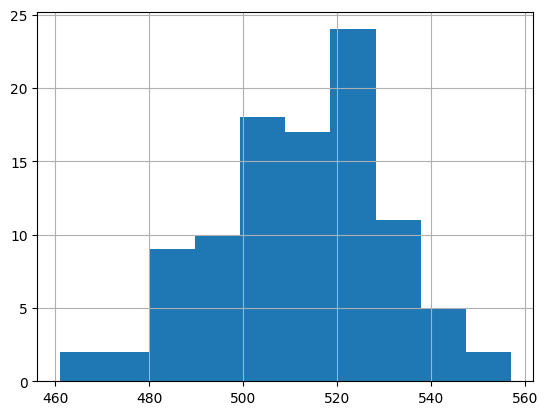

In [ ]:
ss_df['S3'].hist()

In [ ]:
from hybrid.parse import PreconfiguredSimulatorLoader

l = PreconfiguredSimulatorLoader.load_preconfigured('hybrid_n')

In [ ]:
import tests.discover as discover
import os

discover.discover_tests('./', './decaying_isomerization', include_check=True)

Extending test suite from ././decaying_isomerization



[('././decaying_isomerization',
  'model_ss_stiff_initial_ss_ss',
  ParseResults(model=<reactionmodel.model.Model object at 0x29913a520>, parameters={'c1': 1.0, 'c2': 2.0, 'c3': 5e-05}, t=T(t_span=[0.0, 20000.0], t_eval=None), initial_condition={'S12': 1800, 'S3': 0}, simulator_config=GillespieSimulatorFactory(version='1.0', options={}, description="Gillespie's original SSA for homogenous or time inhomogenous processes.")),
  None),
 ('././decaying_isomerization',
  'stiff_hybrid',
  ParseResults(model=<reactionmodel.model.Model object at 0x2992d3790>, parameters={'c1': 1.0, 'c2': 2.0, 'c3': 5e-05}, t=T(t_span=[0.0, 20000.0], t_eval=None), initial_condition={'S1': 1200, 'S2': 600, 'S3': 0}, simulator_config=HybridSimulatorFactory(version='1.0', options={'approximate_rtot': False, 'contrived_no_reaction_rate': None, 'fast_scale': 'deterministic', 'round_randomly': True, 'halt_on_partition_change': False, 'partition_fraction_for_halt': None}, partition_function=NThresholdPartitioner(thre

In [ ]:
l.partition_function

NThresholdPartitioner(threshold=100.0)

In [ ]:
hc_s = l.make_simulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 5e-05


In [ ]:
hc_s.partition_function

<bound method NThresholdPartitioner.partition_function of NThresholdPartitioner(threshold=100.0)>

In [ ]:
pd.DataFrame(hc_s.run_simulations(1, t_span, ic, np.random.default_rng(), end_routine=end_routine))

,S1,S2,S3
0,851.0,425.0,518.0


## Tau leaping

In [ ]:
from hybrid.tau import TauLeapSimulator

t_s = TauLeapSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
    method='implicit'
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 5e-05


In [16]:
tau_df = pd.DataFrame(t_s.run_simulations(1, t_span, ic, np.random.default_rng(), end_routine=end_routine))

/Users/thayer/develop/hybrid/hybrid/tau.py:216: RuntimeWarning: invalid value encountered in divide
  tau1 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1) / np.abs(mu_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:217: RuntimeWarning: invalid value encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))

PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/Users/thayer/develop/hybrid/.venv/lib/python3.9/site-packages/pudb/debugger.py", line 296, in set_trace
    sys.settrace(self.trace_dispatch)



)0PuDB 2024.1 - ?:helpn:next  s:step intob:breakpoint  !:pythoncommand line  285           Variable  286           s:  287           cls: ABC  288             Meta  289           explicit  290             _updat  291             e: nda  292             rray(f  293             loat64  294             ) (3,)  295           mean_0:  296         r   ndarra  297             y(floa  298     @clas   t64) (  299     def i   3,)  300         # N: ndarr  301             ay(flo  302         #   at64)  303         e   (3, 3)  304         # objectiv  305         m   e_func  306         #   tion:  307         d   <funct  308             ion Ta  309             uLeapS  310           Stack:  311           >> impli  312         #    tau_u  313              tau_s  314         y    step *315         u    simul> 316         r    run_s  317              <modu  318     def t    run_c  319         #    run_a  320         p    run_c  321              _pseu  322         p    _run_  323         t    run_c  324

<Axes: >

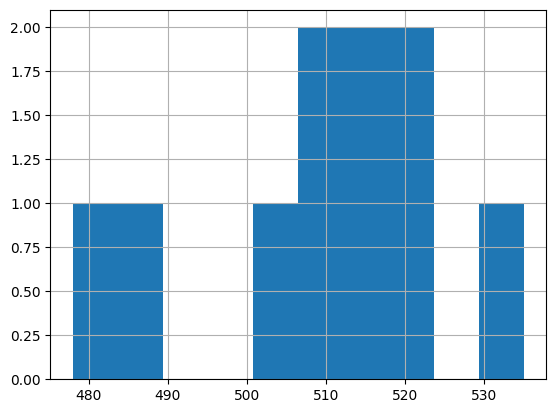

In [ ]:
tau_df['S3'].hist()

In [ ]:
result = t_s.simulate(t_span, ic, np.random.default_rng())

Counter({<TauStepStatus.leap: 0>: 29119})

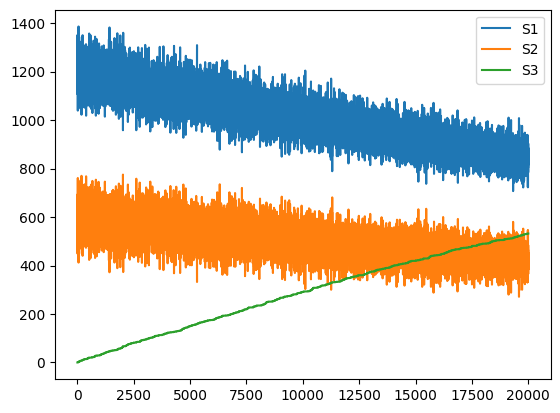

In [ ]:
result.plot(m_decay.legend())
result.status_counter

In [ ]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

h_s = HybridSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 5e-05


In [ ]:
hybrid_df = pd.DataFrame(h_s.run_simulations(10, t_span, ic, np.random.default_rng(), end_routine=end_routine))

<Axes: >

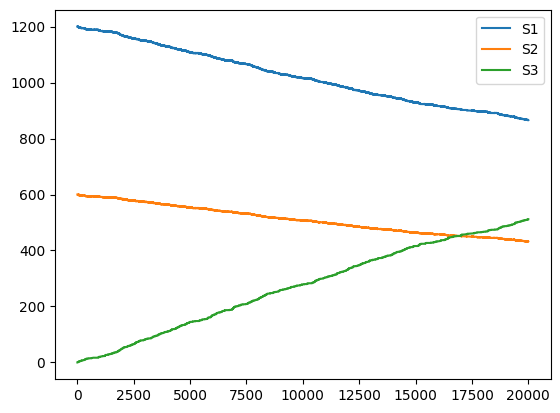

In [ ]:
result = h_s.simulate(t_span, ic, np.random.default_rng())
result.plot(m_decay.legend())

# Immigration + linear death process

In [ ]:
from reactionmodel.model import Species, Reaction, Model
from hybrid.gillespie import GillespieSimulator

S1 = Species('S1')

reactions = [
    Reaction([S1], [], k='r'),
    Reaction([], [S1], k='p')
]

m = Model([S1], reactions)

p = {'r': 1, 'p':100}

s = GillespieSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

Evaluating expression: r => 1.0
Evaluating expression: p => 100.0


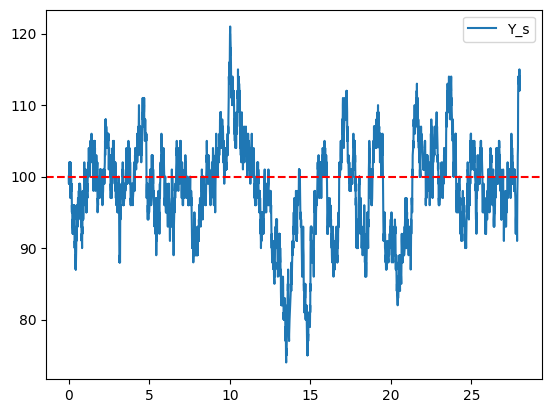

In [ ]:
import numpy as np
result = s.simulate([0.0, 28.0], m.make_initial_condition({'S1': 100}), np.random.default_rng())
ax = result.plot(['Y_s'])
ax.axhline(100, color='r', linestyle='dashed')

In [ ]:
import matplotlib.pyplot as plt
#plt.hist(result.y_history)

In [ ]:
import pandas as pd
r = pd.DataFrame(data={'S': np.squeeze(result.y_history.T)})
r

,S
0,100.0
1,99.0
2,100.0
3,101.0
4,100.0
...,...
5613,113.0
5614,112.0
5615,113.0
5616,114.0


KeyError: 'c1'

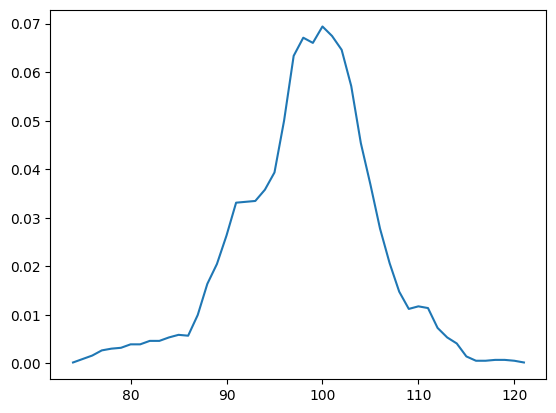

In [ ]:
import scipy.stats

ax = plt.subplot()
x = np.arange(r.min().iloc[0], r.max().iloc[0])

ax.plot([x[0] for x in r.value_counts(normalize=True).sort_index().index.to_numpy()], r.value_counts(normalize=True).sort_index().to_numpy())
#ax = r.value_counts(normalize=True).sort_index().plot()

rv = scipy.stats.poisson(p['p']/p['c1'])
ax.plot(x, rv.pmf(x))

# Test discovery

In [ ]:
import tests.discover as discover

discover.discover_tests('./', include_check=True)

Extending test suite from ./decaying-isomerization



[('./decaying-isomerization',
  'model_ss_stiff_initial_ss_groundtruth',
  ParseResults(model=<reactionmodel.model.Model object at 0x129782430>, parameters={'c1': 1.0, 'c2': 2.0, 'c3': 5e-05}, t=T(t_span=[0.0, 20000.0], t_eval=None), initial_condition={'S12': 1800, 'S3': 0}, simulator_config=GillespieSimulatorFactory(version='1.0', options={}, description="Gillespie's original SSA for homogenous or time inhomogenous processes.")),
  None)]

# Simple experiment idea:

Let's say you have a latent reservoir of size $n$ with variance $v$. As a function of the variance in the reservoir size, how much variance is there in the time until you hit exponential growth? How much variation is there in the re-seeded latent reservoir after a phase of $R_0$ that lasts for $t$ days?

=> how does this translate to your conclusions about probability of mutant emergence given a set standard?
=> how 